In [1]:
import os
from pprint import pprint
import mlflow.pytorch
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/huytrnq/BrainSegmentation.mlflow"
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset
from utils.utils import train, validate
from utils.metric import MetricsMonitor, dice_coefficient, dice_score_3d
from utils.vis import plot_images
from utils.transforms import RobustZNormalization

## Constants

In [2]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
NUM_CLASSES = 4
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01

## Transforms

In [14]:
train_transform = A.Compose([
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    # Spatial Transformations
    A.OneOf([
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.2), rotate=(-30, 30), p=1.0),  # Scaling, Rotation, Shearing
    ], p=0.5),  # 50% chance to apply one of the spatial transforms

    # Other Transformations
    A.OneOf([
        A.HorizontalFlip(p=1.0),  # Mirroring
        A.VerticalFlip(p=1.0),  # Mirroring
    ], p=0.5),

    # Normalize and convert to tensors
    RobustZNormalization(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Include mask augmentation

test_transform = A.Compose([
    # A.Resize(256, 256),
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    # A.Normalize(normalization="min_max", p=1.0),
    RobustZNormalization(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [15]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, cache=True, ignore_background=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

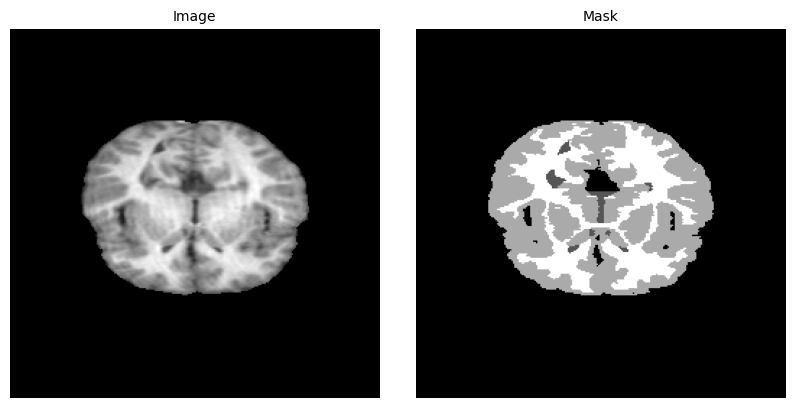

In [16]:
image, mask, volume_idx, slice_idx = train_dataset[129]


plot_images([image.permute(2, 1, 0).numpy(), mask.permute(2, 1, 0).numpy()] , ['Image', 'Mask'], cols=2, figsize=(10, 5))

## Models

In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [19]:
criterion = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

## Training

In [20]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criterion, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criterion, DEVICE, val_monitor)

In [ ]:
## Export Model
torch.save(model.state_dict(), "model.pth")

## Predict

### Load model

In [17]:
logged_model = 'runs:/b825a297281a465ea908e1364f6074d6/model'

# Load the model
model = mlflow.pytorch.load_model(logged_model, map_location=DEVICE)

In [18]:
predictions = []
labels = []
volume_idxs = []
slice_idxs = []
meta_data = val_dataset.metadata

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        volume_idxs.extend(volume_idx.numpy().tolist())
        slice_idxs.extend(slice_idx.numpy().tolist())
        
predictions = torch.cat(predictions, dim=0).detach().cpu()
labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)
print(f"Dice Score: {np.mean(dice_scores)}")

[0.9955854415893555, 0.8991853594779968, 0.8881125450134277, 0.8790041208267212]
Dice Score: 0.9154718667268753


In [10]:
predictions = torch.softmax(predictions.float(), dim=1).cpu().numpy()
predictions = np.argmax(predictions, axis=1)

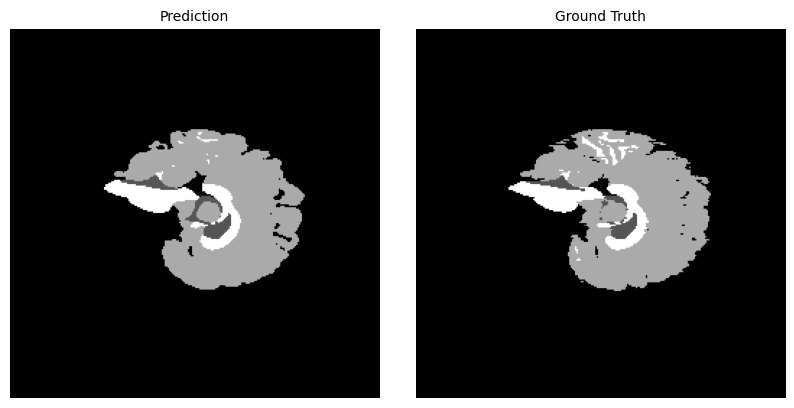

In [11]:
plot_images([predictions[129, :, :], labels[129, :, :].cpu().numpy()], ["Prediction", "Ground Truth"], cols=2)

## Combine 2D segmentation to 3D segmentation

In [12]:
N_TEST = 5
metadata = val_dataset.metadata

In [16]:
# Split the predictions and labels into volumes
predictions = np.array(predictions).reshape(N_TEST, -1, 128, 256)
labels = np.array(labels).reshape(N_TEST, -1, 128, 256)

In [10]:
# Export segmented images
os.makedirs("results", exist_ok=True)

for volume_idx in range(N_TEST):
    print(f"Volume {volume_idx}")
    # Get the metadata for the volume
    image_name = os.path.basename(metadata[volume_idx]["image_path"])
    affine = metadata[volume_idx]["affine"]
    header = metadata[volume_idx]["header"]
    # Get the prediction and label for the volume and remove the padding
    prediction = predictions[volume_idx][:, :, :]
    
    # Export the segmented image
    prediction_nii = nib.Nifti1Image(prediction, affine, header)
    nib.save(prediction_nii, f"results/segmented_{image_name}")

Volume 0


Volume 1
Volume 2
Volume 3
Volume 4


In [19]:
predictions = []
labels = []
volume_idxs = []
slice_idxs = []
meta_data = val_dataset.metadata

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        volume_idxs.extend(volume_idx.numpy().tolist())
        slice_idxs.extend(slice_idx.numpy().tolist())
        
predictions = torch.cat(predictions, dim=0).detach().cpu()
labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)
print(f"Dice Score: {np.mean(dice_scores)}")

#################### 3D Evaluation ####################
# Split the predictions and labels into volumes
predictions = torch.argmax(predictions, dim=1).numpy()
predictions = np.array(predictions).reshape(N_TEST, -1, 128, 256)
labels = np.array(labels).reshape(N_TEST, -1, 128, 256)
dices = dice_score_3d(predictions, labels, num_classes=4)
print(dices)

[0.9955854415893555, 0.8991853594779968, 0.8881125450134277, 0.8790041208267212]
Dice Score: 0.9154718667268753
{0: 0.9960839152336121, 1: 0.7744254469871521, 2: 0.8075240254402161, 3: 0.8756219744682312}


In [153]:
def evaluate(
    model, 
    val_loader, 
    val_dataset, 
    dice_coefficient_fn, 
    dice_score_3d_fn, 
    plane='axial', 
    device='cuda', 
    n_test_volumes=None, 
    input_shape=(128, 256), 
    num_classes=4
):
    """
    Evaluate the model for both 2D and 3D Dice scores for a given plane (axial, coronal, sagittal).

    Args:
        model (torch.nn.Module): Trained model.
        val_loader (DataLoader): Validation data loader.
        val_dataset (Dataset): Validation dataset with metadata.
        dice_coefficient_fn (callable): Function to calculate 2D Dice coefficient.
        dice_score_3d_fn (callable): Function to calculate 3D Dice score.
        plane (str): Evaluation plane ('axial', 'coronal', 'sagittal').
        device (str): Device to perform computation ('cuda' or 'cpu').
        n_test_volumes (int): Number of test volumes for 3D evaluation.
        input_shape (tuple): Shape of input slices (e.g., (128, 256)).
        num_classes (int): Number of segmentation classes.

    Returns:
        dict: Dictionary containing 2D Dice scores, average 2D Dice score,
              3D Dice scores, and average 3D Dice score.
        np.ndarray: Predicted labels.
        np.ndarray: Predicted probabilities.
        np.ndarray: Ground truth labels.
    """
    predictions = []
    labels = []
    volume_idxs = []
    slice_idxs = []
    meta_data = val_dataset.metadata

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predictions.append(outputs)
            labels.append(masks)
            volume_idxs.extend(volume_idx.numpy().tolist())
            slice_idxs.extend(slice_idx.numpy().tolist())

    # Process predictions and labels for 2D evaluation
    predictions = torch.cat(predictions, dim=0).detach().cpu()
    labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
    dice_scores_2d = dice_coefficient_fn(predictions, labels, num_classes=num_classes)
    avg_dice_score_2d = np.mean(dice_scores_2d)

    # Process predictions and labels for 3D evaluation
    prediction_probs = torch.softmax(predictions.float(), dim=1).cpu().view(n_test_volumes, num_classes, -1, *input_shape)
    predictions = torch.argmax(predictions, dim=1).numpy()
    predictions = np.array(predictions).reshape(n_test_volumes, -1, *input_shape)
    labels = np.array(labels).reshape(n_test_volumes, -1, *input_shape)

    # Compute 3D Dice scores
    dice_scores_3d = dice_score_3d_fn(predictions, labels, num_classes=num_classes)
    avg_dice_score_3d = np.mean(list(dice_scores_3d.values()))

    return {
        "Plane": plane,
        "2D Dice Scores": dice_scores_2d,
        "Average 2D Dice Score": avg_dice_score_2d,
        "3D Dice Scores": dice_scores_3d,
        "Average 3D Dice Score": avg_dice_score_3d,
    }, predictions, prediction_probs, labels

## Ensemble

### Axial

In [94]:
axial_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=0, transform=test_transform, cache=True, ignore_background=False)
axial_loader = DataLoader(axial_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [101]:
axial_model_uri = 'runs:/bd5ae7f392d946dab672e51076446e83/model'
# Load the model
axial_model = mlflow.pytorch.load_model(axial_model_uri, map_location=DEVICE)

In [154]:
axial_dices, axial_predictions, axial_probs, axial_labels = evaluate(
    axial_model, 
    axial_loader, 
    axial_dataset, 
    dice_coefficient, 
    dice_score_3d, 
    plane='axial', 
    device=DEVICE, 
    n_test_volumes=5, 
    input_shape=(128, 256)
)

pprint(axial_dices, sort_dicts=True, indent=4)

{   '2D Dice Scores': [   0.9951168298721313,
                          0.9340009689331055,
                          0.9234927892684937,
                          0.8811143040657043],
    '3D Dice Scores': {   0: 0.99653559923172,
                          1: 0.8324748277664185,
                          2: 0.8960431814193726,
                          3: 0.8690069317817688},
    'Average 2D Dice Score': 0.9334312230348587,
    'Average 3D Dice Score': 0.89851513504982,
    'Plane': 'axial'}


### Coronal

In [112]:
coronal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=1, transform=test_transform, cache=True, ignore_background=False)
coronal_loader = DataLoader(coronal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [113]:
coronal_model_uri = 'runs:/8c53f95765b144c29d6e2896e4d06360/model'
# Load the model
coronal_model = mlflow.pytorch.load_model(coronal_model_uri, map_location=DEVICE)

In [155]:
coronal_dices, coronal_predictions, coronal_probs, coronal_labels = evaluate(
    coronal_model, 
    coronal_loader, 
    coronal_dataset, 
    dice_coefficient, 
    dice_score_3d, 
    plane='coronal',
    device=DEVICE, 
    n_test_volumes=5, 
    input_shape=(256, 256)
)

pprint(coronal_dices, sort_dicts=True, indent=4)

{   '2D Dice Scores': [   0.9958999752998352,
                          0.8664706945419312,
                          0.8935020565986633,
                          0.8656147122383118],
    '3D Dice Scores': {   0: 0.9965728521347046,
                          1: 0.797768235206604,
                          2: 0.9065926671028137,
                          3: 0.8959665298461914},
    'Average 2D Dice Score': 0.9053718596696854,
    'Average 3D Dice Score': 0.8992250710725784,
    'Plane': 'coronal'}


### Sagittal

In [13]:
sagittal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
sagittal_loader = DataLoader(sagittal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [14]:
sagittal_model_uri = 'runs:/383766fb8103456ba4463c3bf815ba5a/model'
# Load the model
sagittal_model = mlflow.pytorch.load_model(sagittal_model_uri, map_location=DEVICE)

In [156]:
sagittal_dices, sagittal_predictions, sagittal_probs, sagittal_labels = evaluate(
    sagittal_model, 
    sagittal_loader, 
    sagittal_dataset, 
    dice_coefficient, 
    dice_score_3d, 
    plane='sagittal',
    device=DEVICE, 
    n_test_volumes=5, 
    input_shape=(256, 128)
)

pprint(sagittal_dices, sort_dicts=True, indent=4)

{   '2D Dice Scores': [   0.995225727558136,
                          0.8734736442565918,
                          0.924567699432373,
                          0.8723558187484741],
    '3D Dice Scores': {   0: 0.9966008067131042,
                          1: 0.7183252573013306,
                          2: 0.8955023884773254,
                          3: 0.8633185625076294},
    'Average 2D Dice Score': 0.9164057224988937,
    'Average 3D Dice Score': 0.8684367537498474,
    'Plane': 'sagittal'}


### Ensemble

In [141]:
def ensemble_3d_predictions_with_batch(
    axial_probs, coronal_probs, sagittal_probs, ground_truth, dice_3d_func,
    num_classes=4, smooth=1e-6, input_shape=(256, 128, 256)
):
    """
    Ensemble predictions from axial, coronal, and sagittal views across a batch of images.

    Args:
        axial_probs (torch.Tensor): Axial probabilities ([batch_size, num_slices_axial, num_classes, H, W]).
        coronal_probs (torch.Tensor): Coronal probabilities ([batch_size, num_slices_coronal, num_classes, W, D]).
        sagittal_probs (torch.Tensor): Sagittal probabilities ([batch_size, num_slices_sagittal, num_classes, D, H]).
        ground_truth (torch.Tensor): Ground truth segmentation ([batch_size, D, H, W]).
        dice_3d_func (function): Function to compute 3D Dice scores.
        num_classes (int): Number of segmentation classes.
        smooth (float): Smoothing factor for dice computation.
        input_shape (tuple): Target shape in (D, H, W).

    Returns:
        dict: Dice scores and average Dice score.
        torch.Tensor: Ensemble predictions in [batch_size, D, H, W].
    """
    batch_size, D, H, W = ground_truth.shape

    # Step 1: Align Axial Predictions
    axial_probs = axial_probs.permute(0, 1, 3, 4, 2).numpy()  # [batch_size, num_slices_axial, H, W, num_classes]
    axial_probs_aligned = axial_probs.reshape(batch_size, D, H, W, num_classes).transpose(0, 1, 4, 2, 3)  # [batch_size, D, num_classes, H, W]

    # Step 2: Align Coronal Predictions
    coronal_probs = coronal_probs.permute(0, 1, 3, 4, 2).numpy()  # [batch_size, num_slices_coronal, W, D, num_classes]
    coronal_probs_aligned = coronal_probs.reshape(batch_size, H, W, D, num_classes).transpose(0, 3, 4, 1, 2)  # [batch_size, D, num_classes, H, W]

    # Step 3: Align Sagittal Predictions
    sagittal_probs = sagittal_probs.permute(0, 1, 3, 4, 2).numpy()  # [batch_size, num_slices_sagittal, D, H, num_classes]
    sagittal_probs_aligned = sagittal_probs.reshape(batch_size, W, D, H, num_classes).transpose(0, 2, 4, 3, 1)  # [batch_size, D, num_classes, H, W]

    # Step 4: Average Probabilities
    ensemble_probs = (
        torch.tensor(axial_probs_aligned) +
        torch.tensor(coronal_probs_aligned) +
        torch.tensor(sagittal_probs_aligned)
    ) / 3.0  # [batch_size, D, num_classes, H, W]

    # Step 5: Convert Probabilities to Final Predictions
    ensemble_predictions = torch.argmax(ensemble_probs, dim=2)  # [batch_size, D, H, W]

    return ensemble_predictions

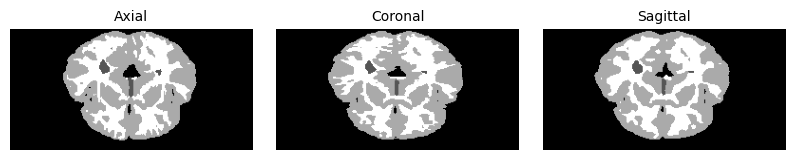

In [106]:
plot_images([axial_predictions.transpose(0,3,2,1)[0, 129, :, :], coronal_predictions.transpose(0,3,1,2)[0, 129, :, :], sagittal_predictions.transpose(0,1,3,2)[0, 129, :, :]], ["Axial", "Coronal", "Sagittal"], cols=3)

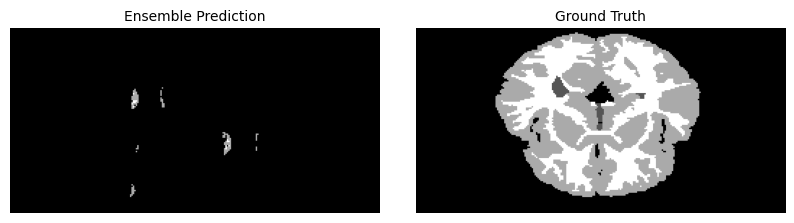

In [145]:
plot_images([ensemble_predictions[0, 200, :, :], labels[0, 129, :, :]], ["Ensemble Prediction", "Ground Truth"], cols=2)

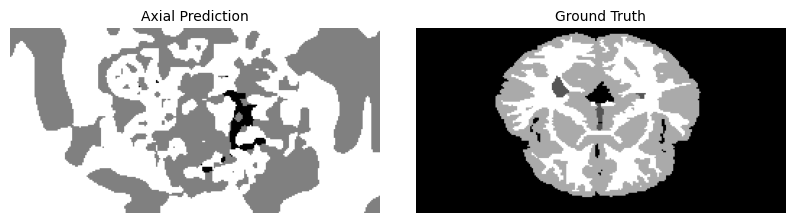

In [157]:
plot_images([torch.argmax(axial_probs, dim=1).numpy()[0, 129, :, :], labels[0, 129, :, :]], ["Axial Prediction", "Ground Truth"], cols=2)